# One shot Learning

## Siamese Network for one-shot learning

<center><img src="https://static.thenounproject.com/png/155075-200.png"></center>

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

**Siamese Neural Networks for One-shot Image Recognition**
*Gregory Koch, Richard Zemel, Ruslan Salakhutdinov*

> The process of learning good features for machine learning applications can be very computationally expensive and may prove difficult in
cases where little data is available. A prototypical example of this is the one-shot learning setting, in which we must correctly make predictions given only a single example of each new
class. In this paper, we explore a method for
learning siamese neural networks which employ
a unique structure to naturally rank similarity between inputs. Once a network has been tuned,
we can then capitalize on powerful discriminative features to generalize the predictive power of
the network not just to new data, but to entirely
new classes from unknown distributions. Using a
convolutional architecture, we are able to achieve
strong results which exceed those of other deep
learning models with near state-of-the-art performance on one-shot classification tasks.

---

<center><img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-0716-0826-5_3/MediaObjects/479517_3_En_3_Fig1_HTML.png"></center>



```
Image from "https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-0716-0826-5_3/MediaObjects/479517_3_En_3_Fig1_HTML.png"
```




## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Other dependencies
import random
import sys
import os
import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt

print('Python version: ', sys.version)
print('Pytorch version: ', torch.__version__)

print("GPU available: {}".format(torch.cuda.is_available()))
print("current GPU index: {}".format(torch.cuda.current_device()))
print("current GPU card name: {}".format(torch.cuda.get_device_name(0)))

Python version:  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Pytorch version:  1.10.0+cu111
GPU available: True
current GPU index: 0
current GPU card name: Tesla K80


## Prepare dataset

### Omniglot Dataset

The Omniglot handwritten character dataset is a dataset for one-shot learning, proposed by Lake et al. It contains 1623 different handwritten characters from 50 different series of alphabets, where each character was handwritten by 20 different people. Each image is 105x105 pixels large. The 50 alphabets are divided into a 30:20 ratio for training and testing, which means that the test set is on a completely new set of characters that are unseen before.
<center><img src="https://i2.wp.com/hugrypiggykim.com/wp-content/uploads/2018/10/omniglot_dataset_characters.jpeg?resize=635%2C289"></center>

https://www.kaggle.com/watesoyan/omniglot

In [2]:
# download omniglot dataset
torchvision.datasets.Omniglot('omniglot', background=True, download=True)
torchvision.datasets.Omniglot('omniglot', background=False, download=True)
;

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_background.zip to omniglot/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting omniglot/omniglot-py/images_evaluation.zip to omniglot/omniglot-py


''

#### What is few-shot learning?
<center><img src="https://blog.kakaocdn.net/dn/RaOdb/btqwWojdR2B/lAkovlKlD4oYyJnE3ko0PK/img.png"></center>

##### One shot learning dataset

In [19]:
class myOmniglot(Dataset):
  def __init__(self, root, train, nway, nquery, nepisode, transform):
    self.train = train
    # nway: number of classes
    self.nway = nway
    # nquery: number of images per class to test
    self.nquery = nquery
    # nepisode: total number of episode
    self.nepisode = nepisode
    self.transform = transform

    # TODO 1. compose char2fnames (e.g. {'korean_character0': ['a.jpg', 'b.jpg', ...]})
    self.char2fnames = dict()
    data_dir = os.path.join(root,
                            'omniglot-py', 
                            'images_background' if self.train else 'images_evaluation')
    
    for language in os.listdir(data_dir):
      lang_dir = os.path.join(data_dir, language)
      for character in os.listdir(lang_dir):
        char_dir = os.path.join(lang_dir, character)
        unique_char = '_'.join([language, character])
        for fname in os.listdir(char_dir):
          file_path = os.path.join(char_dir, fname)
          if unique_char not in self.char2fnames:
            self.char2fnames[unique_char] = list()
          self.char2fnames[unique_char].append(file_path)

  def __len__(self):
    return self.nepisode

  def __getitem__(self, idx):
    # TODO 2. sample n classes (nway)
    chars = random.sample(self.char2fnames.keys(), self.nway)
    
    spt_imgs, spt_labels = [], []
    qry_imgs, qry_labels = [], []
    for i, char in enumerate(chars):
      # TODO 3. sample one example for support & n examples for query
      file_paths = random.sample(self.char2fnames[char], 1 + self.nquery)

      # TODO 4. one support example
      spt_img = self.transform(Image.open(file_paths[0]))
      spt_imgs.append(spt_img)
      spt_labels.append(i)
      

      # TODO 5. n query examples
      for file_path in file_paths[1:]:
        qry_img = self.transform(Image.open(file_path))
        qry_imgs.append(qry_img)
        qry_labels.append(i)

    # stack images, concat labels
    spt_imgs = torch.stack(spt_imgs, dim=0)
    spt_labels = torch.LongTensor(spt_labels)

    qry_imgs = torch.stack(qry_imgs, dim=0)
    qry_labels = torch.LongTensor(qry_labels)

    # shuffle spt images, spt labels
    qry_shuffle_list = list(range(len(qry_imgs)))
    random.shuffle(qry_shuffle_list)

    qry_imgs = qry_imgs[qry_shuffle_list]
    qry_labels = qry_labels[qry_shuffle_list]

    return spt_imgs, spt_labels, qry_imgs, qry_labels

In [20]:
train_dataset = myOmniglot('./omniglot', train=True, nway=5, nquery=15, nepisode=1000, transform=transforms.ToTensor())

In [21]:
test_dataset = myOmniglot('./omniglot', train=False, nway=5, nquery=15, nepisode=500, transform=transforms.ToTensor())

Let's check our dataset

spt_imgs.shape: torch.Size([5, 1, 105, 105])
spt_labels.shape: torch.Size([5])
qry_imgs.shape: torch.Size([75, 1, 105, 105])
qry_labels.shape: torch.Size([75])


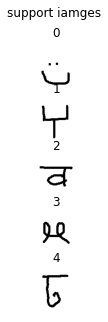

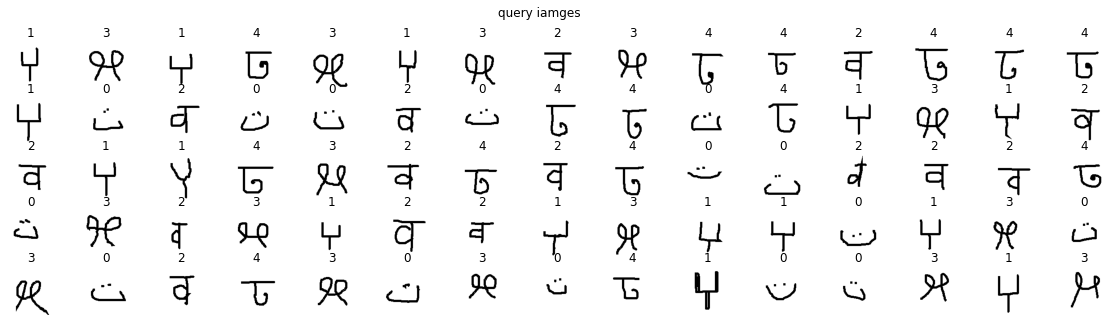

In [22]:
idx = 100

spt_imgs, spt_labels, qry_imgs, qry_labels = train_dataset[idx]
print("spt_imgs.shape: {}".format(spt_imgs.shape))
print("spt_labels.shape: {}".format(spt_labels.shape))
print("qry_imgs.shape: {}".format(qry_imgs.shape))
print("qry_labels.shape: {}".format(qry_labels.shape))

toPILImage = transforms.ToPILImage('L')

plt.figure(figsize=(2, 5))
plt.suptitle('support iamges')
for i in range(len(spt_imgs)):
  plt.subplot(5, 1, i + 1)
  plt.imshow(toPILImage(spt_imgs[i]), cmap='gray')
  plt.axis('off')
  plt.title(spt_labels[i].item())
plt.show()

plt.figure(figsize=(20, 5))
plt.suptitle('query iamges')
for i in range(len(qry_imgs)):
  plt.subplot(5, 15, i + 1)
  plt.imshow(toPILImage(qry_imgs[i]), cmap='gray')
  plt.axis('off')
  plt.title(qry_labels[i].item())
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


spt_imgs.shape: torch.Size([4, 5, 1, 105, 105])
spt_labels.shape: torch.Size([4, 5])
qry_imgs.shape: torch.Size([4, 75, 1, 105, 105])
qry_labels.shape: torch.Size([4, 75])


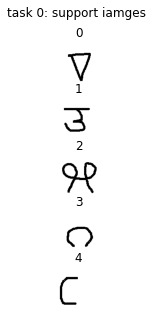

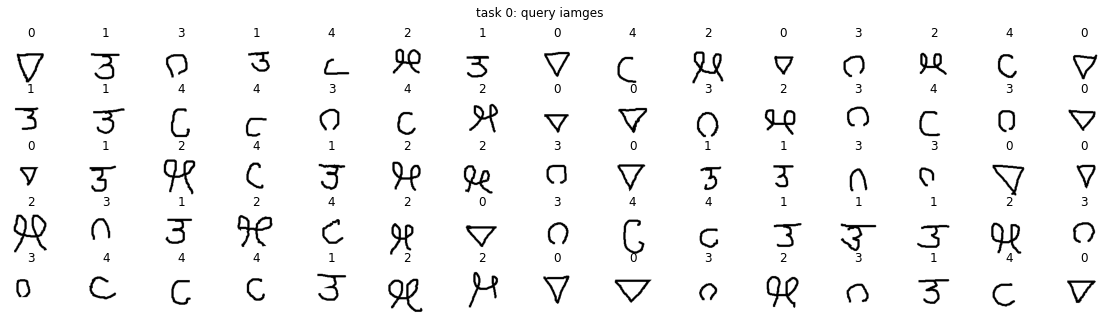

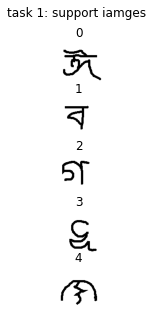

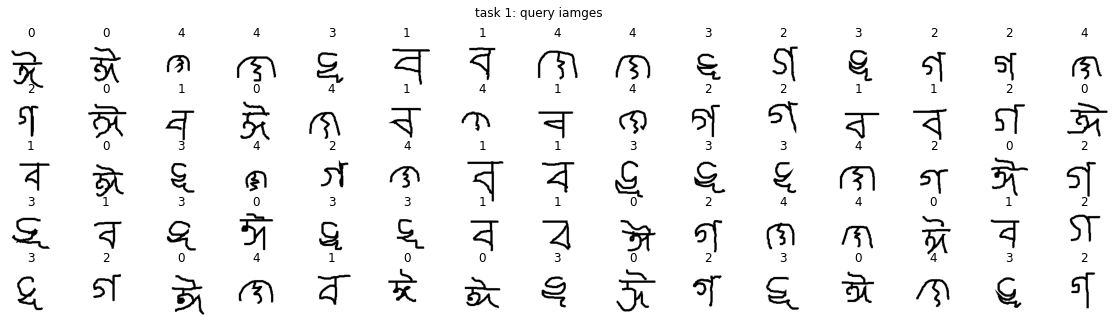

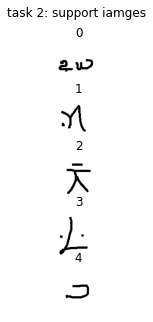

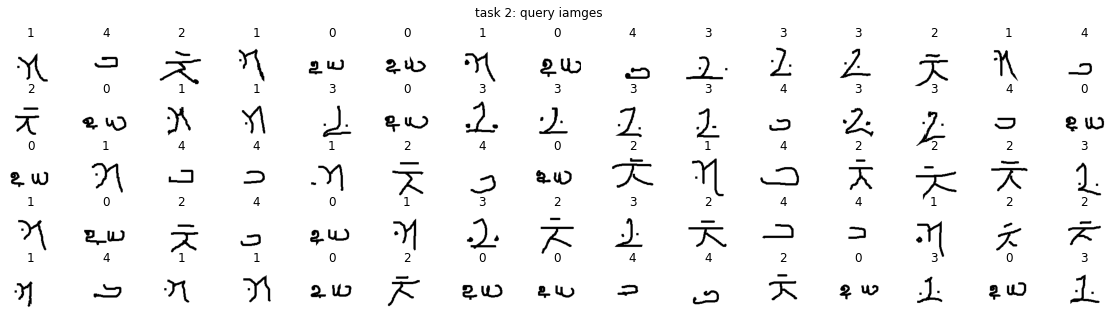

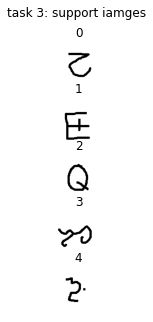

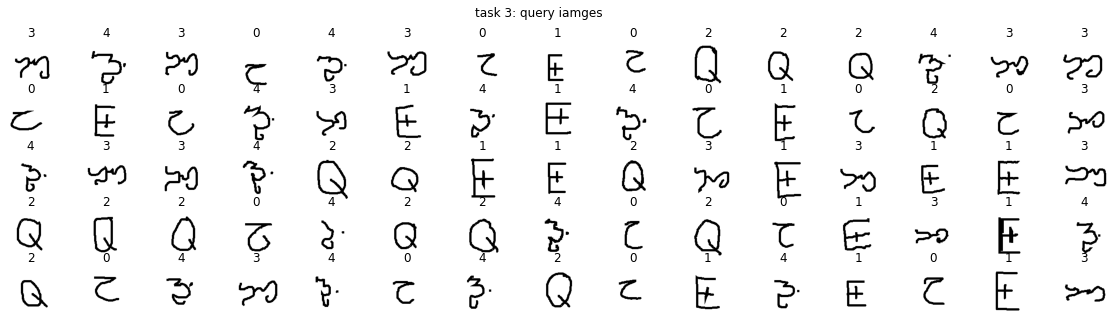

In [ ]:
NTASKS = 4
spt_imgs, spt_labels, qry_imgs, qry_labels = next(iter(DataLoader(train_dataset, batch_size=NTASKS, num_workers=8, drop_last=True)))
print("spt_imgs.shape: {}".format(spt_imgs.shape))
print("spt_labels.shape: {}".format(spt_labels.shape))
print("qry_imgs.shape: {}".format(qry_imgs.shape))
print("qry_labels.shape: {}".format(qry_labels.shape))

for itask in range(NTASKS):
  plt.figure(figsize=(2, 5))
  plt.suptitle('task {}: support iamges'.format(itask))
  for i in range(len(spt_imgs[itask])):
    plt.subplot(5, 1, i + 1)
    plt.imshow(transforms.ToPILImage()(spt_imgs[itask][i]), cmap='gray')
    plt.axis('off')
    plt.title(spt_labels[itask][i].item())
  plt.show()

  plt.figure(figsize=(20, 5))
  plt.suptitle('task {}: query iamges'.format(itask))
  for i in range(len(qry_imgs[itask])):
    plt.subplot(5, 15, i + 1)
    plt.imshow(transforms.ToPILImage()(qry_imgs[itask][i]), cmap='gray')
    plt.axis('off')
    plt.title(qry_labels[itask][i].item())
  plt.show()

## Prepare model
### Siamese Network for one-shot learning

<center><img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FAs6Jf%2FbtqCjQOeLCX%2F14dmKunnmESAWaQ4yYBY81%2Fimg.png'></center>

In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      
      # Conv2d(input_channels, output_channels, kernel_size)
      self.conv1 = nn.Conv2d(1, 64, 10) 
      self.conv2 = nn.Conv2d(64, 128, 7)  
      self.conv3 = nn.Conv2d(128, 128, 4)
      self.conv4 = nn.Conv2d(128, 256, 4)
      self.bn1 = nn.BatchNorm2d(64)
      self.bn2 = nn.BatchNorm2d(128)
      self.bn3 = nn.BatchNorm2d(128)
      self.bn4 = nn.BatchNorm2d(256)
      self.fc1 = nn.Linear(256 * 6 * 6, 4096)
      self.fcOut = nn.Linear(4096, 1)
      self.sigmoid = nn.Sigmoid()
    
  def convs(self, x):
      # out_dim = in_dim - kernel_size + 1  
      #1, 105, 105
      x = F.relu(self.bn1(self.conv1(x)))
      # 64, 96, 96
      x = F.max_pool2d(x, (2,2))
      # 64, 48, 48
      x = F.relu(self.bn2(self.conv2(x)))
      # 128, 42, 42
      x = F.max_pool2d(x, (2,2))
      # 128, 21, 21
      x = F.relu(self.bn3(self.conv3(x)))
      # 128, 18, 18
      x = F.max_pool2d(x, (2,2))
      # 128, 9, 9
      x = F.relu(self.bn4(self.conv4(x)))
      # 256, 6, 6
      return x

  def forward(self, spt_img, qry_img):
      # TODO 1. write forward function
      """
      input: 
        spt_img: a support image
        qry_img: a query image
      outpu:
        similarity score between the support image and the query image
      """
      x1 = self.convs(spt_img)
      x1 = x1.view(-1, 256 * 6 * 6)
      x1 = self.sigmoid(self.fc1(x1))
      x2 = self.convs(qry_img)
      x2 = x2.view(-1, 256 * 6 * 6)
      x2 = self.sigmoid(self.fc1(x2))
      x = torch.abs(x1 - x2)
      x = self.fcOut(x)
      x = self.sigmoid(x)
      return x

In [ ]:
print(spt_imgs.shape, spt_labels.shape)
print(qry_imgs.shape, qry_labels.shape)

torch.Size([4, 5, 1, 105, 105]) torch.Size([4, 5])
torch.Size([4, 75, 1, 105, 105]) torch.Size([4, 75])


In [ ]:
model = Net()
output = model(spt_imgs[0][0].unsqueeze(0), qry_imgs[0][0].unsqueeze(0))
output

tensor([[0.5093]], grad_fn=<SigmoidBackward>)

Since we have 5 support images and 75 query images in an episode,
the model need to calculate similarity score **5 x 75** times!!!

##### Batch version


In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      
      # Conv2d(input_channels, output_channels, kernel_size)
      self.conv1 = nn.Conv2d(1, 64, 10) 
      self.conv2 = nn.Conv2d(64, 128, 7)  
      self.conv3 = nn.Conv2d(128, 128, 4)
      self.conv4 = nn.Conv2d(128, 256, 4)
      self.bn1 = nn.BatchNorm2d(64)
      self.bn2 = nn.BatchNorm2d(128)
      self.bn3 = nn.BatchNorm2d(128)
      self.bn4 = nn.BatchNorm2d(256)
      self.dropout1 = nn.Dropout(0.1)
      self.dropout2 = nn.Dropout(0.5)
      self.fc1 = nn.Linear(256 * 6 * 6, 4096)
      self.fcOut = nn.Linear(4096, 1)
      self.sigmoid = nn.Sigmoid()
  
  def convs(self, x):
      # out_dim = in_dim - kernel_size + 1  
      #1, 105, 105
      x = F.relu(self.bn1(self.conv1(x)))
      # 64, 96, 96
      x = F.max_pool2d(x, (2,2))
      # 64, 48, 48
      x = F.relu(self.bn2(self.conv2(x)))
      # 128, 42, 42
      x = F.max_pool2d(x, (2,2))
      # 128, 21, 21
      x = F.relu(self.bn3(self.conv3(x)))
      # 128, 18, 18
      x = F.max_pool2d(x, (2,2))
      # 128, 9, 9
      x = F.relu(self.bn4(self.conv4(x)))
      # 256, 6, 6
      return x

  def forward(self, spt_imgs, qry_imgs):
      # TODO 1. complete function
      # shape of output should be (# qry_imgs, # spt_imgs) 
      # elem(i,j) of output means similarity score btw i'th qry_img and j'th spt_img
      """
      input:
        spt_imgs: n number of support images
        qry_imgs: n * k number of query images
      output:
        similarity matrix containing a matching score between support images and the query images
      """
      x1 = self.convs(spt_imgs)
      x1 = x1.view(-1, 256 * 6 * 6)
      x1 = self.sigmoid(self.fc1(x1))
      x2 = self.convs(qry_imgs)
      x2 = x2.view(-1, 256 * 6 * 6)
      x2 = self.sigmoid(self.fc1(x2))
      x = torch.abs(x1.unsqueeze(0) - x2.unsqueeze(1)).view(-1, 4096)
      x = self.fcOut(x)
      x = self.sigmoid(x).view(len(qry_imgs), len(spt_imgs))
      return x

In [ ]:
model = Net()
output = model(spt_imgs[0], qry_imgs[0])
output.shape

torch.Size([75, 5])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=8, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = Net()
criterion = nn.BCELoss()

model.to("cuda:0")
criterion.to('cuda:0')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [ ]:
data = next(iter(train_dataloader))
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


4
torch.Size([4, 5, 1, 105, 105])
torch.Size([4, 5])
torch.Size([4, 75, 1, 105, 105])
torch.Size([4, 75])


#### Train model

In [ ]:
for epc in range(100):
  # Train
  model.train()
  for spt_x, spt_y, qry_x, qry_y in tqdm.notebook.tqdm(train_dataloader, desc='train'):
    optimizer.zero_grad()
    total_loss = 0
    for itask in range(4):
      spt_imgs = spt_x[itask].cuda()
      spt_labels = spt_y[itask].cuda()
      qry_imgs = qry_x[itask].cuda()
      qry_labels = qry_y[itask].cuda()

      # TODO 1. get similarity matrix btw spt_imgs & qry_imgs
      similarity_matrix = model(spt_imgs, qry_imgs)
      # TODO 2. calculate loss
      labels = (spt_labels.unsqueeze(0) == qry_labels.unsqueeze(1)).type(torch.float32)
      loss = criterion(similarity_matrix.view(-1), labels.view(-1))

      total_loss = total_loss + loss
    
    total_loss = total_loss / 4
    total_loss.backward()
    optimizer.step()
  scheduler.step()

  # Test
  model.eval()
  test_loss = 0
  test_acc = 0
  test_n = 0
  for spt_x, spt_y, qry_x, qry_y in tqdm.notebook.tqdm(test_dataloader, desc='test'):
    with torch.no_grad():
      spt_imgs = spt_x[0].cuda()
      spt_lbels = spt_y[0].cuda()
      qry_imgs = qry_x[0].cuda()
      qry_labels = qry_y[0].cuda()

      # TODO 1. get similarity matrix btw spt_imgs & qry_imgs
      similarity_matrix = model(spt_imgs, qry_imgs)
      # TODO 2. calculate loss
      labels = (spt_labels.unsqueeze(0) == qry_labels.unsqueeze(1)).type(torch.float32)
      loss = criterion(similarity_matrix.view(-1), labels.view(-1))

      test_loss += loss.item() * len(qry_imgs)
      test_n += len(qry_imgs)
  test_loss /= test_n

  print(f'EPOCH {epc}/{100}:\t test loss: {test_loss}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored